### Labor force nonparticipation due to disability or illness, by CBSA

----

January 15, 2019

Brian Dew, brian.w.dew@gmail.com

This code creates a map showing the share of each center-based statistical area that is not in the labor force due to disability or illness. 

In [1]:
# Import python packages
import pandas as pd
import numpy as np
import calendar

In [2]:
# Generate a list of file names matching the Census microdata files
latest_month = '11/1/2020'
cps_files = [f'{calendar.month_abbr[m.month].lower()}{m.year % 100}pub.dat' 
               for m in pd.date_range(end=latest_month, periods=24, freq='MS')]

ldate = pd.to_datetime(latest_month).strftime('%B %Y')
pdate = (pd.to_datetime(latest_month) - 
         pd.DateOffset(months=23)).strftime('%B %Y')

In [3]:
# Microdata files are fixed-width
# The variable locations are from the data dictionary
cps_vars = [('GTCBSA', 95, 100),     # CBSA (geo area)
            ('PRTAGE', 121, 123),    # Person's age
            ('PEMLR', 179, 181),     # Person's labor market status
            ('PWCMPWGT', 845, 855)]  # Person's composite weight

path = '/home/brian/Documents/CPS/data'  # Location of microdata files

In [4]:
d = {} # Empty dictionary to store monthly files
for file in cps_files:
    d[file] = (pd.read_fwf(f'{path}/{file}', 
                          colspecs=[[v[1], v[2]] for v in cps_vars],
                          names=[v[0] for v in cps_vars])
               .query('PEMLR != -1 and PWCMPWGT > 0 and GTCBSA > 0 '
                      'and PRTAGE > 15 and PRTAGE < 65'))

df = pd.concat(d, ignore_index=True)     # Combine into one dataframe

In [5]:
len(df.groupby('GTCBSA')['PEMLR'].sum().unique())

257

In [6]:
# Check sample size to make sure I have at least 500 observations
min_obs = df.groupby('GTCBSA')['PEMLR'].agg('count').min()
max_obs = df.groupby('GTCBSA')['PEMLR'].agg('count').max()

print(f'Between {min_obs} and {max_obs} observations per CBSA')

Between 327 and 71115 observations per CBSA


In [7]:
# Calculate disabled NILF share of age group, by CBSA
dis = lambda x: np.average(np.where(x['PEMLR'] == 6, 1, 0), weights=x['PWCMPWGT'])
dis_list = df.groupby('GTCBSA').apply(dis)
dis_list.index = dis_list.index.map(str)

In [8]:
# Decide where to split the color codes for the map
bins = [0.004, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.2]
colors = ['#4d9221', '#a1d76a', '#e6f5d0', '#f7f7f7', '#fde0ef', '#e9a3c9', '#c51b7d']
colormap = pd.cut(dis_list, bins, labels=colors).to_dict()

In [9]:
# Getting error when trying to import basemap -- manually moved a file called epsg into the folder below

In [10]:
dis_list.sort_values()

GTCBSA
14500    0.009721
48140    0.014469
28020    0.015849
14010    0.016620
27500    0.017468
           ...   
16620    0.118884
24140    0.122493
34740    0.125180
27740    0.127462
38220    0.129311
Length: 260, dtype: float64

In [11]:
%matplotlib inline
import os
os.environ['PROJ_LIB'] = '/home/brian/miniconda3/share/proj'
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [12]:
# Show contiguous US (and move Hawaii, no data for Alaska):
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

NOTE: shapefile encoding error resolved by opening tl_2013_us_cbsa.dbf with LibreOffice Calc, selecting utf-8 from the import dialogue, and saving.

<Figure size 432x288 with 0 Axes>

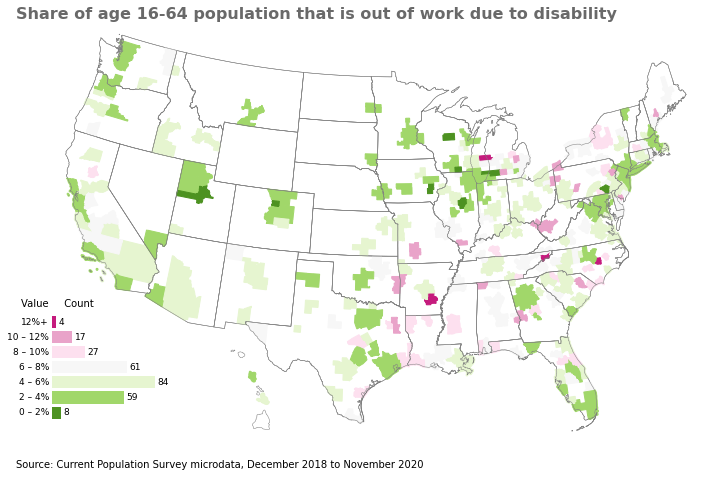

In [13]:
plt.gcf()
plt.figure(figsize=(16,8))

# Read the shapefiles contained in the Shape folder
m.readshapefile('shapefiles/st99_d00', 'states', drawbounds=True, color='gray')
m.readshapefile('shapefiles/tl_2013_us_cbsa', 'cbsa', drawbounds=False)
ax = plt.gca()

for info, shape in zip(m.states_info, m.states):
    seg = shape
    if info['NAME'] == 'Hawaii' and float(info['AREA']) > 0.005:
        seg = [[x + 5200000, y-1400000] for x,y in shape]
    ax.add_patch(Polygon(seg, facecolor='white', edgecolor='gray', linewidth=0.5))

for info, shape in zip(m.cbsa_info, m.cbsa):
    if info['GEOID'] in colormap.keys(): 
        color = colormap[info['GEOID']]
        seg = shape
        if info['NAME'][-2:] == 'HI' and info['RINGNUM'] == 1:
            seg = [[x + 5200000, y-1400000] for x,y in shape]
        ax.add_patch(Polygon(seg, facecolor=color, edgecolor=color))   

plt.title('Share of age 16-64 population that is out of work due to disability', 
          fontsize=16, fontweight=800, loc='left', color='dimgrey')
plt.annotate(f'Source: Current Population Survey microdata, {pdate} to {ldate}',
             (0,0), (0, 0), fontsize=10, xycoords='axes fraction',
             textcoords='offset points', va='top')

ax.axis('off')

ax_inset = inset_axes(ax, width="16%", height="26%", loc=3, borderpad=3.6)
bars = list(pd.cut(dis_list, bins).reset_index().groupby(0)['GTCBSA'].nunique().values)
labels = [f'{int(x.left*100)} – {int(x.right*100)}%' 
          for x in pd.cut(dis_list, bins).sort_values().unique()[:-1]]
labels.append('12%+')
ax_inset.barh(list(range(0, len(bars))), bars, align='center', color=colors)
ax_inset.axis('off')
for i, bar in enumerate(bars):
    ax_inset.text(bar+2, i, bar, fontsize=9, va='center')
for i, label in enumerate(labels):
    ax_inset.text(-2, i, label, fontsize=9, va='center', ha='right')
ax_inset.text(-25, 7, 'Value     Count')

plt.savefig('dis_map.svg', bbox_inches='tight', dpi=500)
plt.show();